In [1]:
import torch
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import os
import torch.nn as nn
from facenet_pytorch import InceptionResnetV1
from torchvision.transforms import transforms

In [2]:
class MultiTaskModel(nn.Module):
    def __init__(self, num_classes):
        super(MultiTaskModel, self).__init__()

        self.backbone = InceptionResnetV1(pretrained='vggface2')
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 256), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        features = self.backbone(x) 
        class_logits = self.classifier(features)
        
        return class_logits

In [3]:
def load_model(model_path, num_classes=2):
    # Initialize model
    model = MultiTaskModel(num_classes=num_classes)
    
    # Load the trained weights
    model.load_state_dict(torch.load(model_path))
    
    # Set model to evaluation mode
    model.eval()
    
    return model

In [4]:
def prepare_image(image_path):
    # Define the same transform as used in training
    transform = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    return image.unsqueeze(0)

In [5]:
def predict_single_image(model, image_path, device):
    # Prepare image
    image = prepare_image(image_path).to(device)
    
    # Get prediction
    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    
    return predicted_class, confidence

In [6]:
def predict_batch(model, image_paths, device):
    predictions = []
    
    for path in image_paths:
        predicted_class, confidence = predict_single_image(model, path, device)
        predictions.append({
            'image_path': path,
            'predicted_class': predicted_class,
            'confidence': confidence
        })
    
    return predictions

In [7]:
if __name__ == "__main__":
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load model
    model_path = 'best_model.pth'  # Path to your saved model
    model = load_model(model_path).to(device)
    
    # Example for single image prediction
    image_path = r'C:\Users\sedth\PycharmProjects\pythonProject\FaceNet\test\20250109_165204_008_saved_jpg.rf.c1387cd22c77586abfbb8205ce349966.jpg'
    class_id, confidence = predict_single_image(model, image_path, device)
    print(f'Single Image Prediction:')
    print(f'Class: {class_id}, Confidence: {confidence:.2%}')
    
    # Example for batch prediction
    test_folder = r'C:\Users\sedth\PycharmProjects\pythonProject\FaceNet\test'
    test_images = [os.path.join(test_folder, f) for f in os.listdir(test_folder) 
                  if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    results = predict_batch(model, test_images, device)
    
    # Print results
    print('\nBatch Predictions:')
    for result in results:
        print(f"Image: {os.path.basename(result['image_path'])}")
        print(f"Class: {result['predicted_class']}")
        print(f"Confidence: {result['confidence']:.2%}")
        print('-' * 50)

D:\Self_Program\D_Program\Lib\site-packages\facenet_pytorch\models\inception_resnet_v1.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cached_f

Single Image Prediction:
Class: 1, Confidence: 98.47%

Batch Predictions:
Image: 20250109_165204_008_saved_jpg.rf.c1387cd22c77586abfbb8205ce349966.jpg
Class: 1
Confidence: 98.47%
--------------------------------------------------
Image: 20250109_165204_013_saved_jpg.rf.ce28097978bf3098c171a037bd67fe7e.jpg
Class: 1
Confidence: 98.43%
--------------------------------------------------
Image: 20250109_165204_023_saved_jpg.rf.9d7bff0c2da7bfbc6867cd0a9ff28b21.jpg
Class: 1
Confidence: 98.24%
--------------------------------------------------
Image: 20250109_165204_026_saved_jpg.rf.8b95f67a29b10b1cee121cae2af0d028.jpg
Class: 1
Confidence: 98.24%
--------------------------------------------------
Image: 20250109_165213_008_saved_jpg.rf.299fb1efee1488a5a514bab76b35796b.jpg
Class: 1
Confidence: 98.51%
--------------------------------------------------
Image: 20250109_165213_009_saved_jpg.rf.2f8c93953c529e068ddd1b23d9d24389.jpg
Class: 1
Confidence: 98.51%
-----------------------------------------

In [8]:
import matplotlib.pyplot as plt
def predict_and_display(model, image_paths, class_names, device, rows=None):
    model.eval()
    
    # Calculate grid dimensions
    n_images = len(image_paths)
    if rows is None:
        rows = (n_images - 1) // 3 + 1
    cols = min(3, n_images)
    
    # Create figure
    plt.figure(figsize=(15, 5*rows))
    
    for idx, image_path in enumerate(image_paths):
        # Load and show original image
        img = Image.open(image_path).convert('RGB')
        
        # Prepare image for prediction
        transform = transforms.Compose([
            transforms.Resize((160, 160)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        
        # Get prediction
        input_tensor = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = model(input_tensor)
            probabilities = F.softmax(outputs, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0][predicted_class].item()
        
        # Create subplot
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(img)
        
        # Set title with prediction and confidence
        title = f'Pred: {class_names[predicted_class]}\nConf: {confidence:.2%}'
        plt.title(title, color='green', pad=10)
        
        # Remove axis ticks
        plt.xticks([])
        plt.yticks([])
    
    plt.tight_layout()
    plt.show()

D:\Self_Program\D_Program\Lib\site-packages\facenet_pytorch\models\inception_resnet_v1.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cached_f

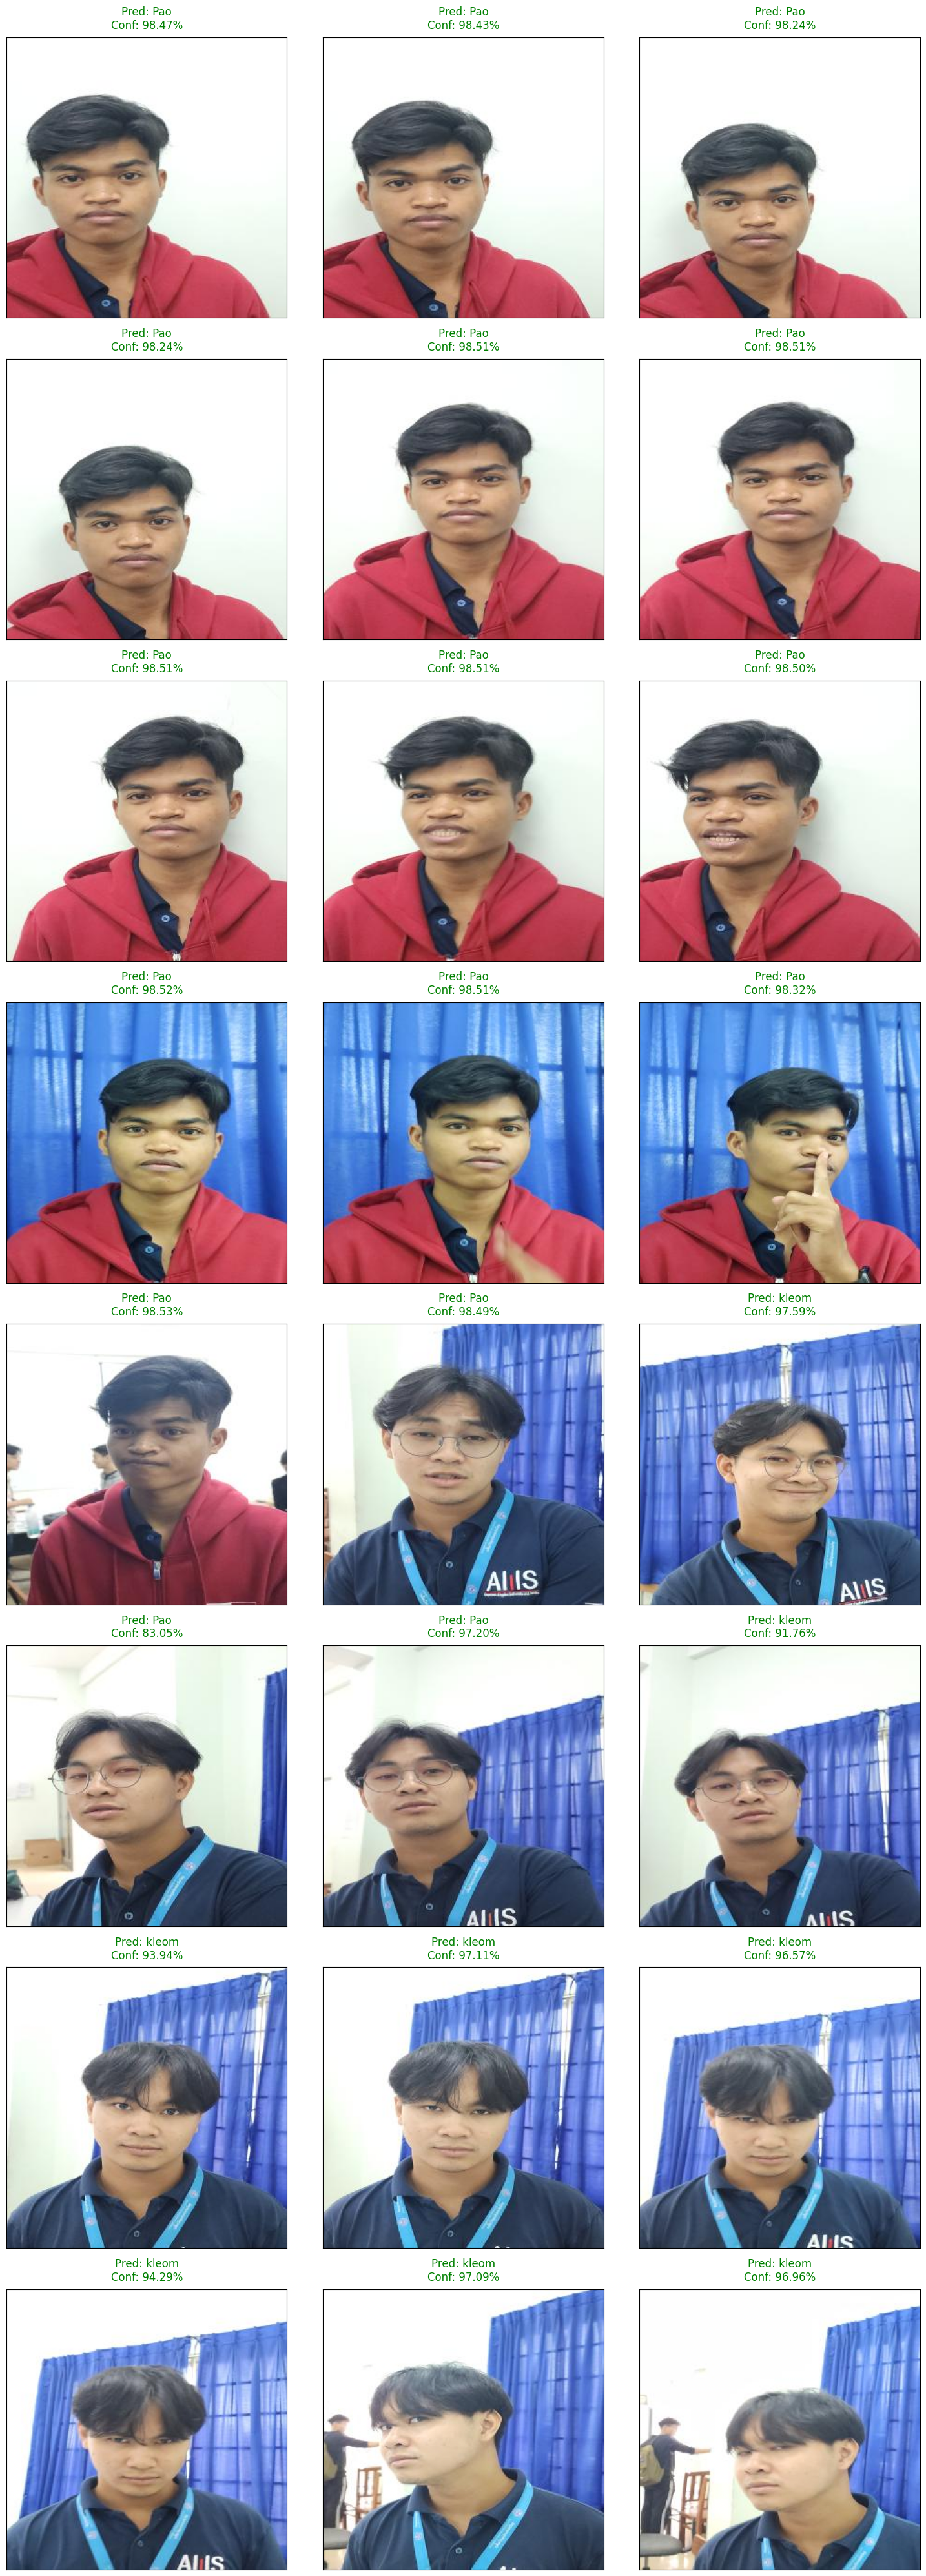

In [9]:
if __name__ == "__main__":
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load model
    model_path = 'best_model.pth'
    model = load_model(model_path).to(device)
    
    # Define class names
    class_names = {
        0: "kleom",  # Replace with your actual class names
        1: "Pao"
    }
    
    # Get test images
    test_folder = r'C:\Users\sedth\PycharmProjects\pythonProject\FaceNet\test'
    test_images = [os.path.join(test_folder, f) for f in os.listdir(test_folder) 
                  if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Display predictions
    predict_and_display(model, test_images, class_names, device)

In [22]:
import numpy as np
def predict_and_analyze_dataset(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    plt.figure(figsize=(20, 10))
    
    # Plot predictions for a batch
    images, labels = next(iter(dataloader))
    images = images.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        predictions = torch.argmax(probabilities, dim=1)
    
    # Display first 8 images from the batch
    for idx in range(min(8, len(images))):
        plt.subplot(2, 4, idx + 1)
        
        # Denormalize image for display
        img = images[idx].cpu()
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        
        # Color code based on correctness
        color = 'green' if predictions[idx] == labels[idx] else 'red'
        title = f'Pred: {class_names[predictions[idx].item()]}\nTrue: {class_names[labels[idx].item()]}'
        plt.title(title, color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

    return predictions.cpu().numpy(), labels.cpu().numpy()

In [24]:
import cv2
import os
import xml.etree.ElementTree as ET
train_path = r'C:\Users\sedth\PycharmProjects\pythonProject\FaceNet\test'
def get_bbox_from_xml(xml_path):
    LABELS={'Kloem':0, 'Pao':1}
    tree = ET.parse(xml_path)
    obj = tree.find('object')
    bbox = obj.find('bndbox')
    label = obj.find('name').text
    return [int(bbox.find('xmin').text), int(bbox.find('ymin').text),
            int(bbox.find('xmax').text), int(bbox.find('ymax').text),LABELS[label]]

images = []
bounding_boxes = []

for file_name in os.listdir(train_path):
    if file_name.endswith('.jpg'):
        img_path = os.path.join(train_path, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        images.append(img)

        xml_file = os.path.join(train_path, file_name[:-4] + '.xml')
        if os.path.exists(xml_file):
            bbox = get_bbox_from_xml(xml_file)
            bounding_boxes.append(bbox)
        else:
            print(f"Annotation file not found for {file_name}")

In [25]:
transform1 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((160, 160)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225]),
])

In [26]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class FaceDetectionDataset(Dataset):
    def __init__(self, images, bounding_boxes, transform=None):
        self.images = images
        self.bounding_boxes = bounding_boxes
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = self.images[idx]
        bbox = self.bounding_boxes[idx][:4]
        label = self.bounding_boxes[idx][4]
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0 
        
        bbox = torch.tensor(bbox, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.int64)

        return image, label


In [27]:
from torch.utils.data import DataLoader
data = FaceDetectionDataset(images, bounding_boxes, transform=transform1)
batch_size = 2
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

In [31]:
# Using the test dataloader
# predictions, labels = predict_and_analyze_dataset(model, dataloader, class_names, device)

D:\Self_Program\D_Program\Lib\site-packages\facenet_pytorch\models\inception_resnet_v1.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cached_f

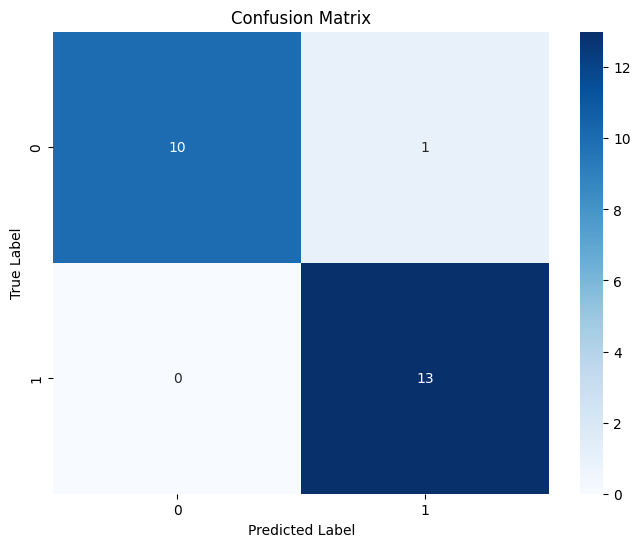


Classification Metrics:
Accuracy: 95.83%
Precision: 92.86%
Recall: 100.00%
F1 Score: 96.30%

Confusion Matrix Details:
True Negatives: 10
False Positives: 1
False Negatives: 0
True Positives: 13


In [30]:
import torch
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def calculate_metrics(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    y_pred = np.array(all_predictions)
    y_true = np.array(all_labels)
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    accuracy = (y_true == y_pred).mean()
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {
        'accuracy': accuracy * 100,
        'precision': precision * 100,
        'recall': recall * 100,
        'f1_score': f1 * 100,
        'confusion_matrix': cm
    }

# Example usage:
if __name__ == "__main__":
    # Load your model and test dataset
    model = load_model('best_model.pth')
    model = model.to(device)
    
    # Calculate metrics
    metrics = calculate_metrics(model, dataloader, device)
    
    # Print results
    print("\nClassification Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.2f}%")
    print(f"Precision: {metrics['precision']:.2f}%")
    print(f"Recall: {metrics['recall']:.2f}%")
    print(f"F1 Score: {metrics['f1_score']:.2f}%")
    
    # Print confusion matrix interpretation
    tn, fp, fn, tp = metrics['confusion_matrix'].ravel()
    print("\nConfusion Matrix Details:")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")